# This notebook trains GRU OR LSTM models (base on model choice) on one building only. dataset contains the data of the third building (as a random exemple) of the original dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torchmetrics import MeanSquaredError
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import torch
import time

In [2]:
import numpy as np

def sMAPE(outputs, targets):
    """
    Symmetric Mean Absolute Percentage Error (sMAPE) for evaluating the model.
    It is the sum of the absolute difference between the predicted and actual values divided by the average of
    the predicted and actual value, therefore giving a percentage measuring the amount of error :
    100/n * sum(|F_t - A_t| / ((|F_t| + |A_t|) / 2)) with t = 1 to n

    :param outputs: predicted values
    :param targets: real values
    :return: sMAPE
    """
    return 100 / len(targets) * torch.sum(
        2 * torch.abs(outputs - targets) / (torch.abs(outputs) + torch.abs(targets))
    )


In [3]:
def create_sequences(data, seq_length):
    """
    Function to preprocess sequential data to make it usable for training neural networks.
    It transforms raw data into input-target pairs

    :param data: the dataframe containing the data or the numpy array containing the data
    :param seq_length: The length of the input sequences. It is the number of consecutive data points used as input to predict the next data point.
    :return: the numpy arrays of the inputs and the targets,
    where the inputs are sequences of consecutive data points and the targets are the immediate next data points.
    """
    if len(data) < seq_length:
        raise ValueError(
            "The length of the data is less than the sequence length")

    xs, ys = [], []
    # Iterate over data indices
    for i in range(len(data) - seq_length):
        if type(data) is pd.DataFrame:
            # Define inputs
            x = data.iloc[i:i + seq_length]

            # Define target
            y = data.iloc[i + seq_length]

        else:
            # Define inputs
            x = data[i:i + seq_length]

            # Define target
            y = data[i + seq_length]

        xs.append(x)
        ys.append(y)

    # Convert lists to numpy arrays
    xs = np.array(xs)
    ys = np.array(ys)

    # Shuffle the sequences
    indices = np.arange(xs.shape[0])
    np.random.shuffle(indices)
    xs = xs[indices]
    ys = ys[indices]

    return xs, ys

In [4]:

class Data(Dataset):
    """
    Pytorch Dataset class for the data
    """

    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return len(self.x_data)



In [5]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        # Number of input features is 12.
        # self.layer_1 = nn.Linear(22, 120)
        # self.layer_2 = nn.Linear(120, 120)
        # self.layer_3 = nn.Linear(120, 120)
        # self.layer_4 = nn.Linear(120, 120)
        # self.layer_5 = nn.Linear(120, 120)
        # self.layer_6 = nn.Linear(120, 120)
        # self.layer_7 = nn.Linear(120, 120)
        # self.layer_out = nn.Linear(120, 1)

        self.layer_1 = nn.Linear(22, 5)
        self.layer_out = nn.Linear(5, 1)
        self.relu = nn.ReLU()

    def forward(self, inputs, device):
        # x = self.relu(self.layer_1(inputs))
        # x = self.relu(self.layer_2(x))
        # x = self.relu(self.layer_3(x))
        # x = self.relu(self.layer_4(x))
        # x = self.relu(self.layer_5(x))
        # x = self.relu(self.layer_6(x))
        # x = self.relu(self.layer_7(x))
        # x = self.layer_out(x)

        x = self.relu(self.layer_1(inputs))
        x = self.layer_out(x)

        return x



In [6]:
class RnnNet(nn.Module):
    """
    RNN model for time series forecasting using LSTM or GRU

    Args:
    - model_choice: choice of RNN model. Default: LSTM
    - input_size: number of features in the input x
    - hidden_size: number of features in the hidden state h
    - num_layers: number of recurrent layers. Default: 2
    - batch_first: if True, then the input and output tensors are provided as (batch, seq, feature). Default: True

    Returns:
    - out: tensor containing the output features h_t from the last layer of the RNN, for each t
    """

    def __init__(self,
                 model_choice,
                 input_size,
                 hidden_size,
                 num_layers,
                 batch_first):
        super().__init__()
        # Define RNN layer
        if model_choice == "LSTM":
            model = nn.LSTM

        elif model_choice == "GRU":
            model = nn.GRU
            
        self.choice_model = model_choice
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        if model_choice == "LSTM" or model_choice == "GRU" :
            self.rnn = model(
                input_size=input_size,
                hidden_size=self.hidden_size,
                num_layers=self.num_layers,
                batch_first=batch_first,
            )
            self.fc = nn.Linear(hidden_size,1)
    def forward(self, x, device):
        # Initialize short-term memory
        h0 = torch.zeros(self.num_layers, x.size(0),
                         self.hidden_size).to(device)
        if self.choice_model == "LSTM":
            # Initialize the long-term memory
            c0 = torch.zeros(self.num_layers, x.size(0),
                             self.hidden_size).to(device)
            long_term_memory = (h0, c0)

        elif self.choice_model == "GRU":
            # GRU merges short-term memory and long-term memory in a single hidden state
            long_term_memory = h0

        if self.choice_model== "LSTM" or self.choice_model == "GRU":
            # Pass all inputs to RNN layer
            out, _ = self.rnn(x, long_term_memory)
            out = self.fc(out[:, -1, :])

        return out



In [7]:
def test_function(net,
                  dataloader_test,
                  scaler,
                  label_scaler,
                  device=torch.device("cpu")):
    """
    Model evaluation on test data
    :param net:
    :param dataloader_test:
    :return:
    """
    # Define MSE metric
    mse = MeanSquaredError().to(device=device)

    net.eval(
    )  #to tell the net that we are running a validation set (no dropout for exemple)
    list_outputs = []
    list_targets = []
    with torch.no_grad():  #to not reservate a memory space for gradients
        for seqs, labels in dataloader_test:
            # Move data to device
            seqs, labels = seqs.float().to(device), labels.float().to(device)
            # seqs = seqs.view(*seqs.shape, 1)
            # Pass seqs to net and squeeze the result
            if net.choice_model == "LSTM" or net.choice_model == "GRU" :
                outputs = net(seqs, device)

            if label_scaler:
                outputs = torch.tensor(scaler.inverse_transform(outputs),
                                       device=device)
                labels = torch.tensor(label_scaler.inverse_transform(labels),
                                      device=device)

            outputs = outputs.squeeze()
            labels = labels.squeeze()

            # Compute loss
            mse(outputs, labels)
            list_targets.append(labels.detach()) #detach() to remove pytorch constraints on the values
            list_outputs.append(outputs.detach())
    # Compute final metric value
    test_mse = mse.compute()
    print(f"Test MSE: {test_mse}")

    return torch.tensor(list_outputs,device = device), torch.tensor(list_targets,device = device), test_mse

In [8]:
def train_function(net,
                   criterion,
                   optimizer,
                   train_loader,
                   n_epochs=5,
                   device=torch.device("cpu")):
    for epoch in range(n_epochs):
        for seqs, labels in train_loader:
            # Move data to device
            seqs, labels = seqs.float().to(device), labels.float().to(device)

            # Reshape model inputs
            #seqs = seqs.view(*seqs.shape, 1)

            # Get model outputs
            if net.choice_model == "LSTM" or net.choice_model == "GRU" :
                outputs = net(seqs, device)
            

            # Compute loss
            loss = criterion(outputs, labels)  #calculate the loss function
            optimizer.zero_grad()  # to reset the graph of gradients
            loss.backward()  #to calculate the graph of gradients
            optimizer.step()  #to update each gradient
        print(f"Epoch {epoch + 1}, Loss: {loss.item()}")
    return net



(12469, 10, 1) (12469, 1)
Memory usage for creating RnnNet model: 762.734375 MiB
Epoch 1, Loss: 2.891439199447632
Epoch 2, Loss: 1.8721003532409668
Epoch 3, Loss: 2.700467109680176
Epoch 4, Loss: 1.9929808378219604
Epoch 5, Loss: 2.0196237564086914
Epoch 6, Loss: 1.8682219982147217
Epoch 7, Loss: 1.9446837902069092
Epoch 8, Loss: 1.9842236042022705
Epoch 9, Loss: 2.188711643218994
Epoch 10, Loss: 2.0623326301574707
Epoch 11, Loss: 2.0055525302886963
Epoch 12, Loss: 1.966328740119934
Epoch 13, Loss: 1.8423395156860352
Epoch 14, Loss: 2.1721527576446533
Epoch 15, Loss: 1.9480470418930054
Epoch 16, Loss: 2.213775157928467
Epoch 17, Loss: 1.5915062427520752
Epoch 18, Loss: 1.9411895275115967
Epoch 19, Loss: 1.273313045501709
Epoch 20, Loss: 1.654775619506836
Epoch 21, Loss: 1.5367987155914307
Epoch 22, Loss: 1.8757069110870361
Epoch 23, Loss: 2.022613525390625
Epoch 24, Loss: 1.9166675806045532
Epoch 25, Loss: 1.9564871788024902
Epoch 26, Loss: 1.836257815361023
Epoch 27, Loss: 1.851267337

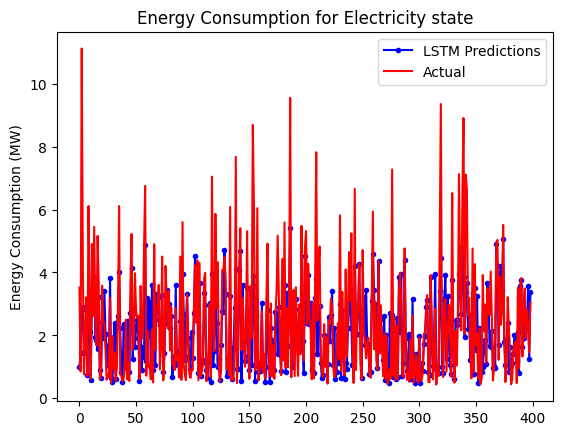

In [9]:
%reload_ext memory_profiler

import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from memory_profiler import memory_usage
from torch.utils.data import DataLoader, Dataset

# Assuming the Data class and other necessary functions (e.g., RnnNet, train_function, test_function, sMAPE, create_sequences) are already defined

# Load and preprocess the dataset
model_choice = "GRU"
file_path = '/kaggle/input/dataset/residential_1004.pkl'
df = pd.read_pickle(file_path)
df["ID"] = df["ID"].astype("category")
df["time_code"] = df["time_code"].astype("uint16")
df = df.set_index("date_time")
df = df["consumption"].resample("h", label='right', closed='right').sum().to_frame()

# Define the device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Scaling the input data
sc = None  # MinMaxScaler()
label_sc = None  # MinMaxScaler()
window_size = 10  # number of data points used as input to predict the next data point
data = create_sequences(df["2009-07-14":"2010-12-15"].values, window_size)
data_test = create_sequences(df["2010-12-15":"2011-01-01"].values, window_size)

# Use create_sequences to create inputs and targets
train_x, train_y = create_sequences(
    data if sc else df["2009-07-14":"2010-12-15"], window_size)
print(train_x.shape, train_y.shape)

test_x, test_y = create_sequences(
    data_test if label_sc else df["2010-12-15":"2011-01-01"], window_size)

# Pytorch data loaders/generators
batch_size = 512
train_data = Data(torch.FloatTensor(train_x), torch.FloatTensor(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
del train_x, train_y

# Test data
test_data = Data(torch.FloatTensor(test_x), torch.FloatTensor(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1)
del test_x, test_y

# Parameters for the model
n_hidden = 32  # number of features in the hidden state
n_layers = 2  # number of recurrent layers.
n_epochs = 50
lr = 0.001
input_dim = next(iter(train_loader))[0].shape[2]  # number of features in the input x

# Define the model
if model_choice == "LSTM" or model_choice == "GRU":
    model = RnnNet(model_choice=model_choice, input_size=input_dim, hidden_size=n_hidden, num_layers=n_layers, batch_first=True).to(device)

# Measure memory usage of model creation
model_mem_usage = memory_usage((RnnNet, (model_choice, input_dim, n_hidden, n_layers, True), {}), interval=0.1)
print(f"Memory usage for creating RnnNet model: {max(model_mem_usage)} MiB")

# Defining loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
%reload_ext memory_profiler
# Measure memory usage of train_function
train_mem_usage = memory_usage((train_function, (model, criterion, optimizer, train_loader, n_epochs, device), {}), interval=0.1)
print(f"Memory usage for training function: {max(train_mem_usage)} MiB")

# Train the model with LSTM
net = train_function(model, criterion, optimizer, train_loader, n_epochs, device)

# Evaluate the LSTM model
net.to(device)
list_outputs, list_targets, test_mse = test_function(net, test_loader, sc, label_sc, torch.device(device))

s_mape = round(sMAPE(list_outputs, list_targets).cpu().item(), 3)
print(f"sMAPE: {s_mape}%")

# Visualizations
plt.plot(list_outputs.cpu(), "-o", color="blue", label="LSTM Predictions", markersize=3)
plt.plot(list_targets.cpu(), color="red", label="Actual")
plt.ylabel("Energy Consumption (MW)")
plt.title(f"Energy Consumption for Electricity state")
plt.legend()
plt.show()
